In [21]:
from module.Iris_recognition import *
from module.Periocular_recognition import *
from module.score_fusion import *
import os

In [22]:
fs_path = 'temp_data/fusion_scores_enhanced_80.npz'
f_path = 'temp_data/features_final_80.npz'

svm_path = 'model/svm_VGG16_fusion_enha_80.pickle'
rfc_path = 'model/rfc_VGG16_fusion_enha_80.pickle'
lr_path = 'model/lr_VGG16_fusion_enha_80.pickle'

In [23]:
# # load the features from the file
# with np.load('temp_data/features.npz') as data:
#     features_train_a = data['features_train_a']
#     features_train_b = data['features_train_b']
#     y_train_final = data['label_train']
#     img_label_train = data['img_label_train']
    
#     features_test_a = data['features_test_a']
#     features_test_b = data['features_test_b']
#     y_test_final = data['label_test']
#     img_label_test = data['img_label_test']

In [24]:
# load the features from the file
with np.load(fs_path) as data:
    fusion_scores_train = data['fusion_scores_train']
    fusion_scores_test = data['fusion_scores_test']

In [25]:
with np.load(f_path) as data:
    X_train_final = data['X_train_final']
    y_train_final = data['y_train_final']
    label_train_pair = data['label_train_pair']
    
    X_test_final = data['X_test_final']
    y_test_final = data['y_test_final']
    label_test_pair = data['label_test_pair']

In [26]:
import pickle
from sklearnex import patch_sklearn
patch_sklearn()
import sklearn.svm as svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [27]:
import logging

logger = logging.getLogger("sklearnex")
logger.setLevel(logging.WARNING)  # Set the logger's logging level to WARNING or higher

In [28]:
# X_train_scaled, X_test_scaled = feature_preprocessing(features_train_a, features_test_a, features_train_b, features_test_b, fusion_scores_train, fusion_scores_test, use_fusion=True)

In [29]:
svm = pickle.load(open(svm_path, "rb"))

In [30]:
rfc = pickle.load(open(rfc_path, "rb"))

In [31]:
lr = pickle.load(open(lr_path, "rb"))

In [32]:
# # load the features from the file
# with np.load('temp_data/iris_norm_all.npz') as data:
#     iris_norm_L = data['iris_norm_L']
#     iris_norm_R = data['iris_norm_R']

In [33]:
# predict, ground_truth = accuracy_score_multi_thread(img_label_test, rfc, iris_norm_L, iris_norm_R, X_test_scaled)

In [34]:
predict, ground_truth = accuracy_score_preload(label_test_pair, lr, fusion_scores_test, X_test_final)

  0%|          | 0/16000 [00:00<?, ?it/s]

In [35]:
predict = []
ground_truth = []
classifiers = [svm, rfc, lr]

for classifier in classifiers:
    pred, gt = accuracy_score_preload(label_test_pair, classifier, fusion_scores_test, X_test_final)
    predict.append(pred)
    ground_truth.append(gt)

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

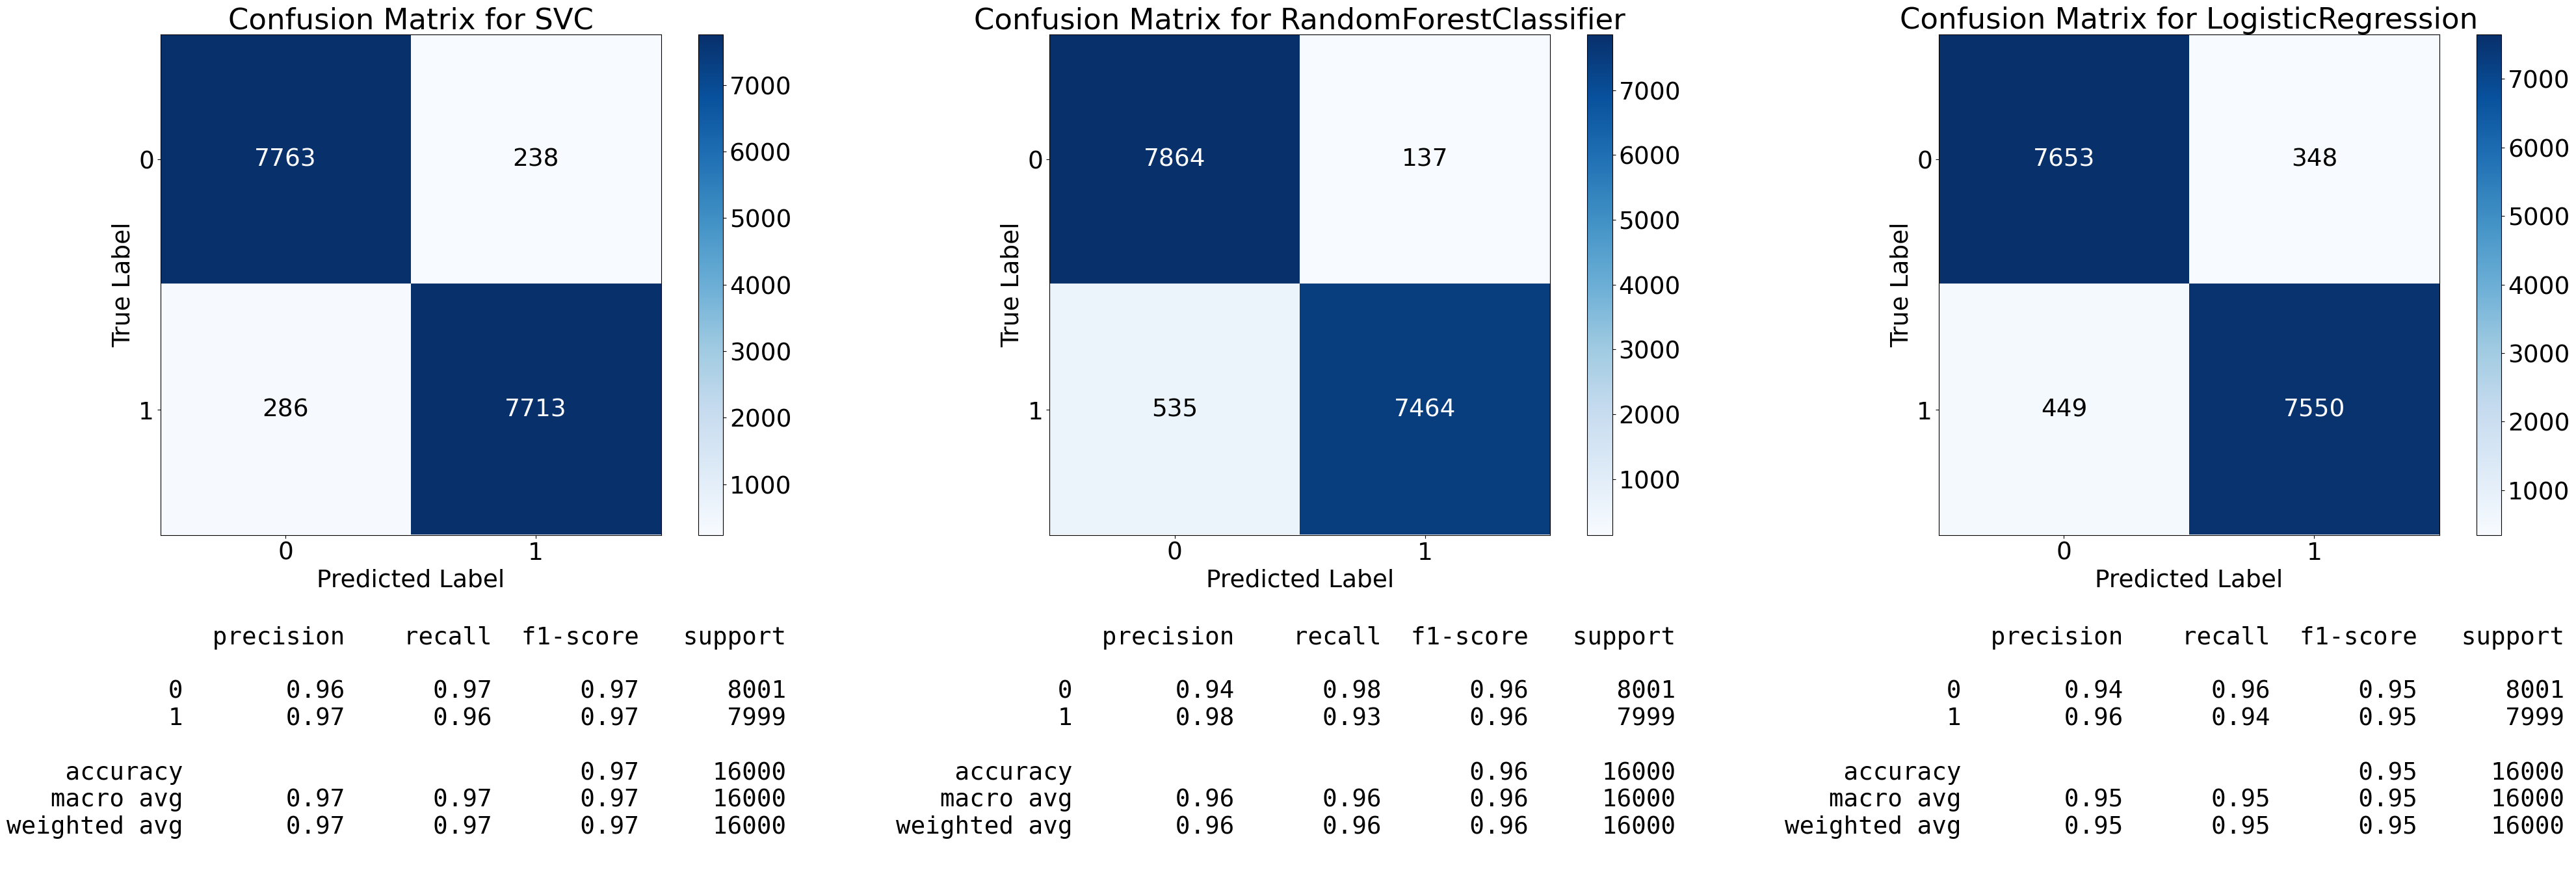

In [36]:
plot_cm_mul(ground_truth, predict, classifiers, 3)

In [37]:
# plot_cm(ground_truth[0], predict[0])

Show result in ERR formula below:
$$
EER = \frac{FAR + FRR}{2}
$$

In [38]:
from sklearn.metrics import roc_curve

In [39]:
def calculate_far_frr(y_true, y_score):
    # Calculate False positive rate (FPR) and True positive rate (TPR)
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    # Calculate False Accept Rate (FAR) and False Reject Rate (FRR)
    far = fpr
    frr = 1 - tpr
    return far, frr, thresholds

def calculate_eer(y_true, y_score):
    far, frr, thresholds = calculate_far_frr(y_true, y_score)
    # Find where FAR and FRR are closest to each other
    eer_index = np.nanargmin(np.absolute((far - frr)))
    eer = np.mean([far[eer_index], frr[eer_index]])
    return eer

In [40]:
# Assuming ground_truth and predict are your data
for test in range(len(classifiers)):
    eer = calculate_eer(ground_truth[test], predict[test])
    print(f"Equal Error Rate of {classifiers[test]}: {round(eer*100, 2)}%")

Equal Error Rate of SVC(C=10, gamma=0.0001, verbose=2): 3.28%
Equal Error Rate of RandomForestClassifier(min_samples_split=5, n_estimators=200): 4.2%
Equal Error Rate of LogisticRegression(C=0.1, penalty='l1', solver='liblinear'): 4.98%
